# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
import tensorflow as tf

## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

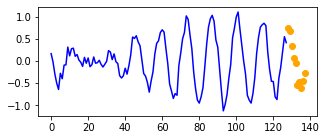

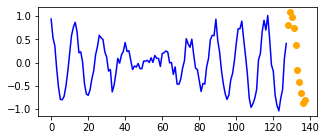

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [3]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 feartures. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.

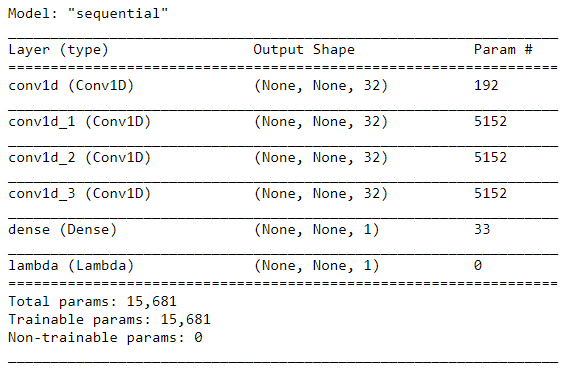

In [4]:
# split data
X_train = X[:800, :, :]
Y_train = Y[:800, :, :]
X_test = X[800:, :, :]
Y_test = Y[800:, :, :]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(800, 128, 1)
(800, 10, 1)
(200, 128, 1)
(200, 10, 1)


In [5]:
# define the model
def slice(x, slice_length):
    return x[:,-slice_length:,:]

model = Sequential()
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1)))
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1)))
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1)))
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1)))
model.add(Dense(1))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss="MSE")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
____________________________________________________

In [6]:
# train model
fit_model = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/100
25/25 - 1s - loss: 0.2271 - val_loss: 0.0353
Epoch 2/100
25/25 - 0s - loss: 0.0370 - val_loss: 0.0273
Epoch 3/100
25/25 - 0s - loss: 0.0285 - val_loss: 0.0236
Epoch 4/100
25/25 - 0s - loss: 0.0270 - val_loss: 0.0250
Epoch 5/100
25/25 - 0s - loss: 0.0257 - val_loss: 0.0256
Epoch 6/100
25/25 - 0s - loss: 0.0289 - val_loss: 0.0236
Epoch 7/100
25/25 - 0s - loss: 0.0263 - val_loss: 0.0223
Epoch 8/100
25/25 - 0s - loss: 0.0254 - val_loss: 0.0227
Epoch 9/100
25/25 - 0s - loss: 0.0257 - val_loss: 0.0232
Epoch 10/100
25/25 - 0s - loss: 0.0274 - val_loss: 0.0224
Epoch 11/100
25/25 - 0s - loss: 0.0263 - val_loss: 0.0220
Epoch 12/100
25/25 - 0s - loss: 0.0251 - val_loss: 0.0232
Epoch 13/100
25/25 - 0s - loss: 0.0258 - val_loss: 0.0220
Epoch 14/100
25/25 - 0s - loss: 0.0254 - val_loss: 0.0256
Epoch 15/100
25/25 - 0s - loss: 0.0250 - val_loss: 0.0229
Epoch 16/100
25/25 - 0s - loss: 0.0243 - val_loss: 0.0240
Epoch 17/100
25/25 - 0s - loss: 0.0266 - val_loss: 0.0228
Epoch 18/100
25/25 - 0s

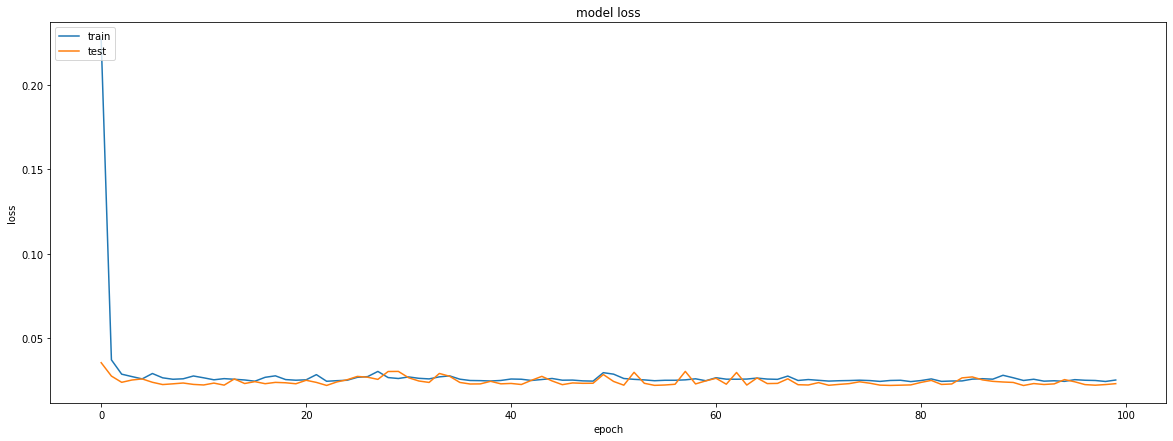

In [7]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.plot(fit_model.history['loss'])
axes.plot(fit_model.history['val_loss'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left')

### Make repeated predictions



Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [8]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
y_pred = model.predict(x_test).reshape(-1) #Predicts 10 value
print(y_pred)
print(y_pred.shape)

(1, 128, 1)
(1, 10, 1)
[ 0.846068    0.7807409   0.5685308   0.2566824  -0.0880135  -0.39363778
 -0.59829086 -0.6627478  -0.5780125  -0.36630487]
(10,)


Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.  

In [9]:
def predict_10(x_data, n=12):
    for i in range(n):
        y_pred = model.predict(x_data)
        x_data = np.append(x_data, y_pred, axis=1)
    return x_data

y_pred = predict_10(x_test)
print(y_pred.shape)

(1, 248, 1)


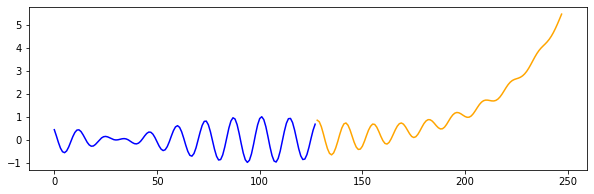

In [10]:
plt.figure(num=None, figsize=(10, 3))  
plt.plot(range(0, seq_length), y_pred[0,:128,0],'b-')
plt.plot(range(seq_length, y_pred.shape[1]), y_pred[0,128:,0],'b-', color='orange')
plt.show()

## B) 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)

Build the same network as in A) but this time with dilation_rates 1,2,4,8 

In [11]:
# split data
X_train = X[:800, :, :]
Y_train = Y[:800, :, :]
X_test = X[800:, :, :]
Y_test = Y[800:, :, :]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(800, 128, 1)
(800, 10, 1)
(200, 128, 1)
(200, 10, 1)


In [12]:
# define the model
def slice(x, slice_length):
    return x[:,-slice_length:,:]

model = Sequential()
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1), dilation_rate=1))
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1), dilation_rate=2))
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1), dilation_rate=4))
model.add(Convolution1D(32, kernel_size=5, input_shape=(None, 1), dilation_rate=8))
model.add(Dense(1))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss="MSE")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

In [13]:
# train model
fit_model = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/100
25/25 - 1s - loss: 0.4440 - val_loss: 0.0703
Epoch 2/100
25/25 - 0s - loss: 0.0249 - val_loss: 0.0165
Epoch 3/100
25/25 - 0s - loss: 0.0140 - val_loss: 0.0119
Epoch 4/100
25/25 - 0s - loss: 0.0125 - val_loss: 0.0120
Epoch 5/100
25/25 - 0s - loss: 0.0125 - val_loss: 0.0119
Epoch 6/100
25/25 - 0s - loss: 0.0129 - val_loss: 0.0118
Epoch 7/100
25/25 - 0s - loss: 0.0126 - val_loss: 0.0119
Epoch 8/100
25/25 - 0s - loss: 0.0125 - val_loss: 0.0116
Epoch 9/100
25/25 - 0s - loss: 0.0122 - val_loss: 0.0116
Epoch 10/100
25/25 - 0s - loss: 0.0125 - val_loss: 0.0116
Epoch 11/100
25/25 - 0s - loss: 0.0123 - val_loss: 0.0121
Epoch 12/100
25/25 - 0s - loss: 0.0129 - val_loss: 0.0110
Epoch 13/100
25/25 - 0s - loss: 0.0125 - val_loss: 0.0113
Epoch 14/100
25/25 - 0s - loss: 0.0122 - val_loss: 0.0112
Epoch 15/100
25/25 - 0s - loss: 0.0122 - val_loss: 0.0116
Epoch 16/100
25/25 - 0s - loss: 0.0123 - val_loss: 0.0126
Epoch 17/100
25/25 - 0s - loss: 0.0124 - val_loss: 0.0110
Epoch 18/100
25/25 - 0s

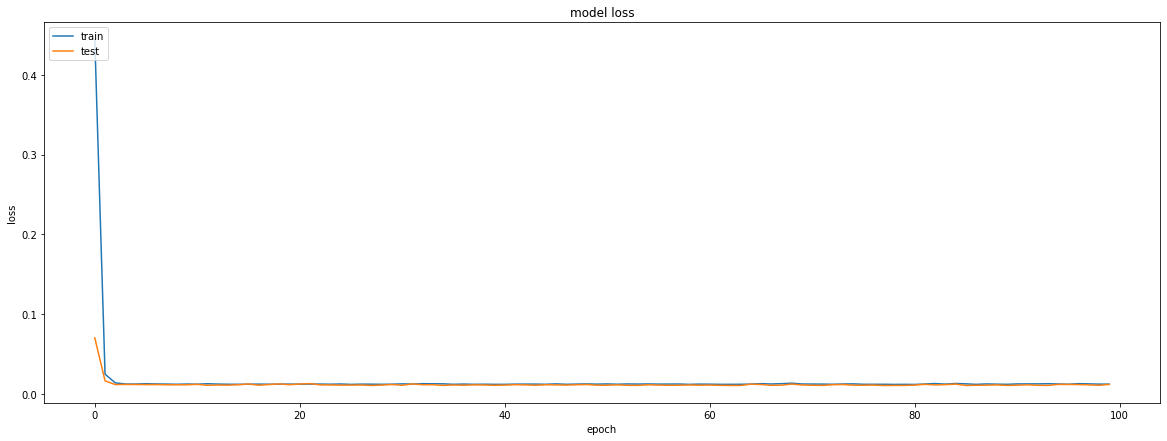

In [14]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.plot(fit_model.history['loss'])
axes.plot(fit_model.history['val_loss'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left')

### Make repeated predictions
As in A) make preaded preditions on noise less data.

(1, 248, 1)


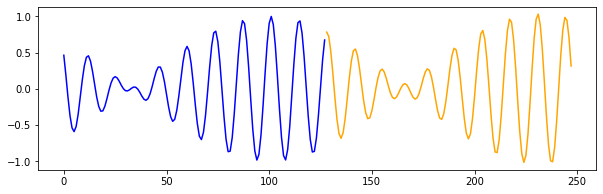

In [15]:
x_test, y_test = gen_data(size=1, noise=0.0)

y_pred = predict_10(x_test)
print(y_pred.shape)

plt.figure(num=None, figsize=(10, 3))  
plt.plot(range(0, seq_length), y_pred[0,:128,0],'b-')
plt.plot(range(seq_length, y_pred.shape[1]), y_pred[0,128:,0],'b-', color='orange')
plt.show()

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

In [25]:
# split data
X_train = X[:800, :, :]
Y_train = Y[:800, :, :]
X_test = X[800:, :, :]
Y_test = Y[800:, :, :]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(800, 128, 1)
(800, 10, 1)
(200, 128, 1)
(200, 10, 1)


In [30]:
# define the model
def slice(x, slice_length):
    return x[:,-slice_length:,:]

model = Sequential()
model.add(SimpleRNN(12, return_sequences=True, input_shape=(None, 1)))
model.add(Dense(1))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss="MSE")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 12)          168       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           13        
_________________________________________________________________
lambda_5 (Lambda)            (None, None, 1)           0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [31]:
# train model
fit_model = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/100
25/25 - 1s - loss: 0.0702 - val_loss: 0.0337
Epoch 2/100
25/25 - 0s - loss: 0.0316 - val_loss: 0.0296
Epoch 3/100
25/25 - 0s - loss: 0.0292 - val_loss: 0.0282
Epoch 4/100
25/25 - 0s - loss: 0.0285 - val_loss: 0.0274
Epoch 5/100
25/25 - 0s - loss: 0.0284 - val_loss: 0.0273
Epoch 6/100
25/25 - 0s - loss: 0.0275 - val_loss: 0.0262
Epoch 7/100
25/25 - 0s - loss: 0.0278 - val_loss: 0.0265
Epoch 8/100
25/25 - 0s - loss: 0.0276 - val_loss: 0.0267
Epoch 9/100
25/25 - 0s - loss: 0.0285 - val_loss: 0.0270
Epoch 10/100
25/25 - 0s - loss: 0.0282 - val_loss: 0.0253
Epoch 11/100
25/25 - 0s - loss: 0.0271 - val_loss: 0.0254
Epoch 12/100
25/25 - 0s - loss: 0.0272 - val_loss: 0.0256
Epoch 13/100
25/25 - 0s - loss: 0.0275 - val_loss: 0.0251
Epoch 14/100
25/25 - 0s - loss: 0.0270 - val_loss: 0.0247
Epoch 15/100
25/25 - 0s - loss: 0.0277 - val_loss: 0.0250
Epoch 16/100
25/25 - 0s - loss: 0.0273 - val_loss: 0.0248
Epoch 17/100
25/25 - 0s - loss: 0.0274 - val_loss: 0.0243
Epoch 18/100
25/25 - 0s

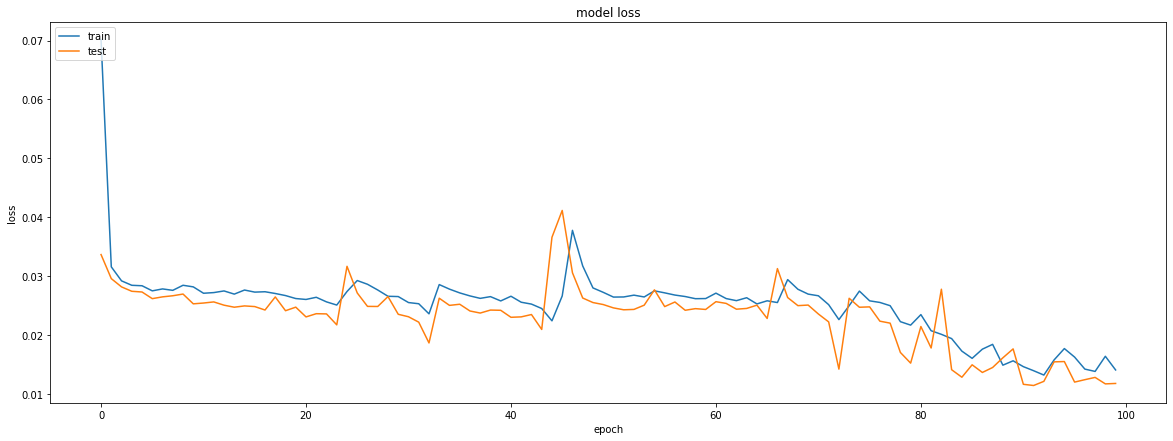

In [32]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.plot(fit_model.history['loss'])
axes.plot(fit_model.history['val_loss'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left')

### Make repeated predictions
As in A) make preaded preditions on noise less data.

(1, 248, 1)


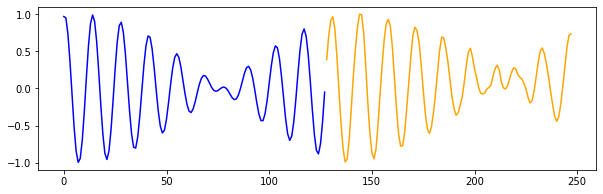

In [33]:
x_test, y_test = gen_data(size=1, noise=0.0)

y_pred = predict_10(x_test)
print(y_pred.shape)

plt.figure(num=None, figsize=(10, 3))  
plt.plot(range(0, seq_length), y_pred[0,:128,0],'b-')
plt.plot(range(seq_length, y_pred.shape[1]), y_pred[0,128:,0],'b-', color='orange')
plt.show()

## D) LSTM Cell
Repeat C) but now with an LSTM cell.

In [34]:
# split data
X_train = X[:800, :, :]
Y_train = Y[:800, :, :]
X_test = X[800:, :, :]
Y_test = Y[800:, :, :]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(800, 128, 1)
(800, 10, 1)
(200, 128, 1)
(200, 10, 1)


In [36]:
# define the model
def slice(x, slice_length):
    return x[:,-slice_length:,:]

model = Sequential()
model.add(LSTM(12, return_sequences=True, input_shape=(None, 1)))
model.add(Dense(1))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss="MSE")
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 12)          672       
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           13        
_________________________________________________________________
lambda_7 (Lambda)            (None, None, 1)           0         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [37]:
# train model
fit_model = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/100
25/25 - 2s - loss: 0.0594 - val_loss: 0.0312
Epoch 2/100
25/25 - 0s - loss: 0.0304 - val_loss: 0.0295
Epoch 3/100
25/25 - 0s - loss: 0.0292 - val_loss: 0.0280
Epoch 4/100
25/25 - 0s - loss: 0.0288 - val_loss: 0.0271
Epoch 5/100
25/25 - 0s - loss: 0.0283 - val_loss: 0.0269
Epoch 6/100
25/25 - 0s - loss: 0.0275 - val_loss: 0.0264
Epoch 7/100
25/25 - 0s - loss: 0.0273 - val_loss: 0.0258
Epoch 8/100
25/25 - 0s - loss: 0.0262 - val_loss: 0.0238
Epoch 9/100
25/25 - 0s - loss: 0.0229 - val_loss: 0.0208
Epoch 10/100
25/25 - 0s - loss: 0.0200 - val_loss: 0.0173
Epoch 11/100
25/25 - 0s - loss: 0.0182 - val_loss: 0.0168
Epoch 12/100
25/25 - 0s - loss: 0.0171 - val_loss: 0.0152
Epoch 13/100
25/25 - 0s - loss: 0.0175 - val_loss: 0.0168
Epoch 14/100
25/25 - 0s - loss: 0.0167 - val_loss: 0.0177
Epoch 15/100
25/25 - 0s - loss: 0.0167 - val_loss: 0.0146
Epoch 16/100
25/25 - 0s - loss: 0.0159 - val_loss: 0.0165
Epoch 17/100
25/25 - 0s - loss: 0.0161 - val_loss: 0.0146
Epoch 18/100
25/25 - 0s

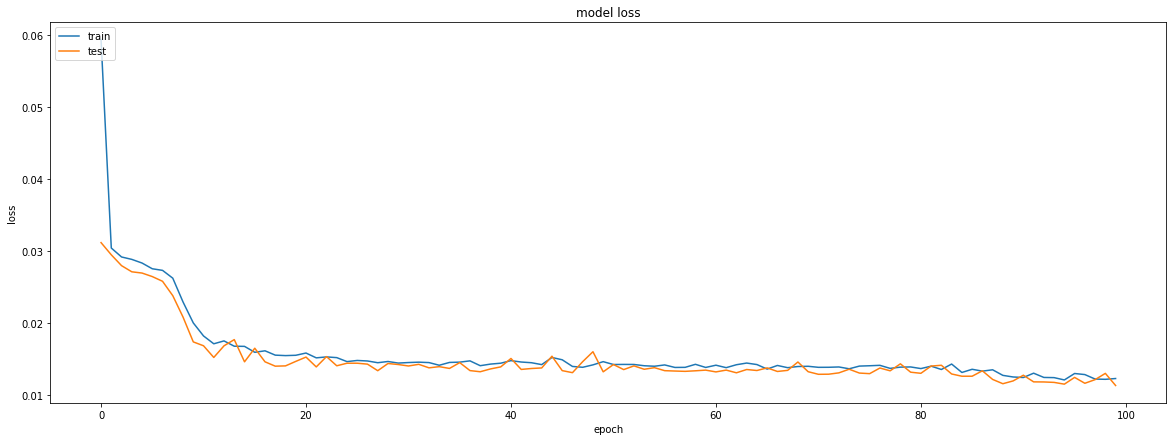

In [38]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.plot(fit_model.history['loss'])
axes.plot(fit_model.history['val_loss'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left')

### Make repeated predictions

(1, 248, 1)


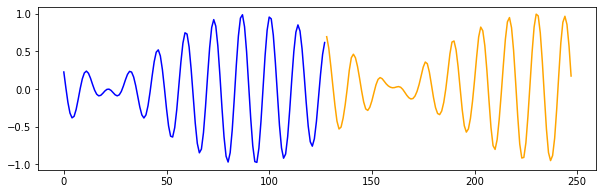

In [39]:
x_test, y_test = gen_data(size=1, noise=0.0)

y_pred = predict_10(x_test)
print(y_pred.shape)

plt.figure(num=None, figsize=(10, 3))  
plt.plot(range(0, seq_length), y_pred[0,:128,0],'b-')
plt.plot(range(seq_length, y_pred.shape[1]), y_pred[0,128:,0],'b-', color='orange')
plt.show()